# Architecture Transformer pour le NLP : Génération de Texte en Français 

Ce notebook enrichit l'architecture Transformer de base avec trois techniques d'optimisation :

1. **⚡ Warmup LR Schedule** - Augmentation progressive du learning rate pour stabiliser l'entraînement
2. **🔍 Beam Search** - Recherche sophistiquée pour une génération de texte optimale
3. **🌡️ Temperature Tuning** - Contrôle de la créativité dans la génération (0.5-1.5)

### Pourquoi ces améliorations ?

- **Warmup** : Évite la divergence en début d'entraînement avec des gradients instables
- **Beam Search** : Explore plusieurs hypothèses en parallèle au lieu d'un seul chemin
- **Temperature** : Permet d'ajuster entre génération conservatrice (0.5) et créative (1.5)

Ces techniques sont utilisées dans **tous les LLMs modernes** (GPT, BERT, etc.) !

## 1. Imports et Configuration

In [1]:
# Bibliothèques principales
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, HTML, display
import re
import unicodedata
from collections import Counter

# TensorFlow et Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.utils import plot_model

# Configuration GPU
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU(s) détecté(s): {len(gpus)} - Croissance mémoire activée")
    else:
        print("⚠️  Aucun GPU détecté - Utilisation du CPU")
except Exception as e:
    print(f"Configuration GPU: {e}")

# Configuration graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Reproductibilité
np.random.seed(42)
tf.random.set_seed(42)

print(f"\n📦 TensorFlow version: {tf.__version__}")
print(f"📦 Keras version: {keras.__version__}")

2025-11-05 16:10:08.431051: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-05 16:10:08.518055: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-05 16:10:09.496213: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


✅ GPU(s) détecté(s): 1 - Croissance mémoire activée

📦 TensorFlow version: 2.20.0
📦 Keras version: 3.11.3


## 2. Dataset : Proverbes et Citations Français

In [2]:
# Corpus étendu de textes en français (400+ phrases)
corpus_francais = [
    # Proverbes français classiques (50 proverbes)
    "Petit à petit, l'oiseau fait son nid.",
    "Qui vivra verra.",
    "L'habit ne fait pas le moine.",
    "Pierre qui roule n'amasse pas mousse.",
    "Tout vient à point à qui sait attendre.",
    "La nuit porte conseil.",
    "Mieux vaut tard que jamais.",
    "Il n'y a pas de fumée sans feu.",
    "Les chiens aboient, la caravane passe.",
    "Chat échaudé craint l'eau froide.",
    "Qui ne tente rien n'a rien.",
    "L'argent ne fait pas le bonheur.",
    "Les jours se suivent et ne se ressemblent pas.",
    "Il faut battre le fer tant qu'il est chaud.",
    "Qui sème le vent récolte la tempête.",
    "Deux précautions valent mieux qu'une.",
    "Ventre affamé n'a point d'oreilles.",
    "Qui ne risque rien n'a rien.",
    "Après la pluie, le beau temps.",
    "L'union fait la force.",
    "Les grands esprits se rencontrent.",
    "Loin des yeux, loin du cœur.",
    "Qui dort dîne.",
    "La parole est d'argent, le silence est d'or.",
    "Il n'est jamais trop tard pour bien faire.",
    "Rira bien qui rira le dernier.",
    "Tous les chemins mènent à Rome.",
    "Une hirondelle ne fait pas le printemps.",
    "Qui aime bien châtie bien.",
    "La fin justifie les moyens.",
    "Tel père, tel fils.",
    "Comme on fait son lit, on se couche.",
    "Un tiens vaut mieux que deux tu l'auras.",
    "Aux innocents les mains pleines.",
    "Quand le chat n'est pas là, les souris dansent.",
    "Il faut tourner sept fois sa langue dans sa bouche.",
    "Qui vole un œuf vole un bœuf.",
    "À chaque jour suffit sa peine.",
    "Les petits ruisseaux font les grandes rivières.",
    "Paris ne s'est pas fait en un jour.",
    "Tant va la cruche à l'eau qu'à la fin elle se casse.",
    "La faim chasse le loup du bois.",
    "L'homme propose et Dieu dispose.",
    "Chose promise, chose due.",
    "Les absents ont toujours tort.",
    "La raison du plus fort est toujours la meilleure.",
    "À bon chat, bon rat.",
    "Les conseilleurs ne sont pas les payeurs.",
    "Comparaison n'est pas raison.",
    "Il ne faut pas vendre la peau de l'ours avant de l'avoir tué.",
    
    # Citations sur la vie (60 citations)
    "La vie est belle quand on sait la regarder.",
    "Le savoir est la seule richesse qu'on ne peut pas voler.",
    "Un sourire coûte moins cher que l'électricité mais donne autant de lumière.",
    "Le bonheur n'est pas une destination, c'est une façon de voyager.",
    "Chaque jour est une nouvelle chance de changer sa vie.",
    "La patience est la clé de la réussite.",
    "Les rêves sont les graines de la réalité.",
    "L'échec est le fondement de la réussite.",
    "Le temps guérit toutes les blessures.",
    "La vérité finit toujours par triompher.",
    "L'amour est plus fort que la haine.",
    "La connaissance éclaire l'esprit.",
    "Le travail acharné porte ses fruits.",
    "La curiosité est le moteur de la découverte.",
    "L'honnêteté est toujours récompensée.",
    "La simplicité est la sophistication suprême.",
    "Le silence est parfois la meilleure réponse.",
    "L'espoir fait vivre.",
    "La beauté est dans l'œil de celui qui regarde.",
    "Le voyage est plus important que la destination.",
    "La liberté n'a pas de prix.",
    "L'imagination est plus importante que le savoir.",
    "La qualité vaut mieux que la quantité.",
    "Le présent est un cadeau précieux.",
    "La musique adoucit les mœurs.",
    "L'éducation ouvre toutes les portes.",
    "La nature est un livre ouvert.",
    "Le rire est le meilleur des remèdes.",
    "La gratitude transforme ce que nous avons en suffisance.",
    "Le changement est la seule constante.",
    "La vie commence là où commence ta zone de confort.",
    "Chaque instant est un nouveau départ.",
    "La persévérance est le chemin du succès.",
    "Les obstacles sont des opportunités déguisées.",
    "Le courage, c'est d'avoir peur et d'avancer quand même.",
    "La sagesse vient avec l'expérience.",
    "Le meilleur moment pour planter un arbre était il y a vingt ans.",
    "Le second meilleur moment est maintenant.",
    "La confiance en soi est le premier secret du succès.",
    "Les grandes choses ont de petits commencements.",
    "L'optimisme est une forme de courage.",
    "La discipline est le pont entre les objectifs et l'accomplissement.",
    "Le succès est la somme de petits efforts répétés jour après jour.",
    "La vie est trop courte pour être petite.",
    "Fais de ta vie un rêve et d'un rêve une réalité.",
    "Le bonheur est une direction, pas un lieu.",
    "Chaque expert a été un jour un débutant.",
    "La motivation te fait commencer, l'habitude te fait continuer.",
    "Le seul moyen de faire du bon travail est d'aimer ce que tu fais.",
    "La créativité exige le courage de lâcher prise sur les certitudes.",
    "L'action est la clé fondamentale de tout succès.",
    "Le pessimiste voit la difficulté dans chaque opportunité.",
    "L'optimiste voit l'opportunité dans chaque difficulté.",
    "La vie est comme une bicyclette, il faut avancer pour ne pas perdre l'équilibre.",
    "Sois le changement que tu veux voir dans le monde.",
    "Le talent gagne des matchs, mais le travail d'équipe gagne des championnats.",
    "La vraie générosité envers l'avenir consiste à tout donner au présent.",
    "L'important n'est pas de convaincre mais de donner à réfléchir.",
    "Le doute est le commencement de la sagesse.",
    "La perfection est atteinte non pas lorsqu'il n'y a plus rien à ajouter.",
    
    # Phrases sur la nature (50 phrases)
    "Le soleil brille dans le ciel bleu.",
    "Les oiseaux chantent dans les arbres.",
    "La pluie tombe doucement sur la terre.",
    "Le vent souffle à travers les feuilles.",
    "Les fleurs poussent au printemps.",
    "La lune éclaire la nuit étoilée.",
    "Les vagues déferlent sur le rivage.",
    "La neige recouvre les montagnes en hiver.",
    "Les papillons volent de fleur en fleur.",
    "L'eau de la rivière coule paisiblement.",
    "Les nuages dansent dans le ciel.",
    "Le chant du rossignol résonne dans la forêt.",
    "Les étoiles scintillent dans la nuit noire.",
    "Le parfum des roses embaume le jardin.",
    "Les feuilles d'automne tombent doucement.",
    "La rosée du matin perle sur l'herbe.",
    "Le tonnerre gronde au loin.",
    "L'arc-en-ciel apparaît après l'orage.",
    "Les abeilles butinent les fleurs sauvages.",
    "Le crépuscule peint le ciel de mille couleurs.",
    "La mer s'étend à perte de vue.",
    "Les arbres se balancent sous la brise légère.",
    "Le givre recouvre les branches en hiver.",
    "Les grenouilles coassent au bord de l'étang.",
    "Le soleil se couche derrière les collines.",
    "Les montagnes se dressent majestueusement.",
    "La cascade tombe avec fracas.",
    "Les champignons poussent dans le sous-bois.",
    "Le brouillard enveloppe la vallée.",
    "Les écureuils grimpent aux arbres.",
    "La tempête fait rage sur l'océan.",
    "Les lucioles illuminent la nuit d'été.",
    "Le coucou annonce le retour du printemps.",
    "Les iris fleurissent au bord de l'eau.",
    "La pleine lune éclaire le paysage.",
    "Les hirondelles volent bas avant la pluie.",
    "Le vent d'automne emporte les feuilles mortes.",
    "Les bourgeons éclosent au printemps.",
    "La brume matinale se dissipe lentement.",
    "Les cigales chantent par les chaudes journées d'été.",
    "Le gel dessine des motifs sur les vitres.",
    "Les nuages s'amoncellent avant l'orage.",
    "Le vent du nord apporte le froid.",
    "Les premières gouttes de pluie rafraîchissent l'air.",
    "La nature s'éveille avec le printemps.",
    "Les stalactites pendent du toit en hiver.",
    "Le soleil réchauffe la terre.",
    "Les champs de blé ondulent sous le vent.",
    "La forêt se pare de ses couleurs d'automne.",
    "Les marmottes sifflent dans la montagne.",
    
    # Phrases sur les actions et valeurs (60 phrases)
    "Il faut toujours croire en ses rêves.",
    "Apprendre est un voyage sans fin.",
    "Le courage n'est pas l'absence de peur.",
    "Chaque erreur est une leçon précieuse.",
    "La persévérance mène au succès.",
    "L'amitié est un trésor inestimable.",
    "Le respect est la base de toute relation.",
    "La générosité enrichit celui qui donne.",
    "La compassion ouvre les cœurs.",
    "L'empathie crée des ponts entre les gens.",
    "La tolérance est une vertu essentielle.",
    "Le pardon libère l'âme.",
    "La bienveillance illumine le monde.",
    "L'humilité est la marque des grands.",
    "La sincérité forge la confiance.",
    "L'intégrité guide nos actions.",
    "La fidélité renforce les liens.",
    "La loyauté est rare et précieuse.",
    "La solidarité unit les communautés.",
    "L'entraide fait avancer l'humanité.",
    "La coopération multiplie les forces.",
    "Le dialogue résout les conflits.",
    "L'écoute est un art subtil.",
    "La communication rapproche les individus.",
    "La transparence établit la confiance.",
    "L'authenticité attire les autres.",
    "La modestie sied aux sages.",
    "La prudence évite bien des malheurs.",
    "La sagesse vient avec l'âge.",
    "La réflexion précède l'action.",
    "La méditation apaise l'esprit.",
    "La concentration améliore les performances.",
    "La détermination surmonte les obstacles.",
    "L'ambition pousse à se dépasser.",
    "La volonté forge le caractère.",
    "La ténacité vient à bout de tout.",
    "La constance mène à l'excellence.",
    "La régularité engendre le progrès.",
    "L'assiduité porte ses fruits.",
    "Le dévouement mérite le respect.",
    "L'engagement inspire les autres.",
    "La passion anime l'existence.",
    "L'enthousiasme est contagieux.",
    "La joie de vivre illumine chaque instant.",
    "L'optimisme transforme les défis en opportunités.",
    "La gratitude multiplie le bonheur.",
    "La reconnaissance honore les bienfaiteurs.",
    "L'appréciation valorise les petites choses.",
    "La mindfulness ancre dans le présent.",
    "La sérénité apporte la paix intérieure.",
    "Le calme dans la tempête montre la force.",
    "La résilience permet de rebondir.",
    "L'adaptabilité est essentielle au changement.",
    "La flexibilité ouvre de nouvelles voies.",
    "L'innovation révolutionne le monde.",
    "La créativité n'a pas de limites.",
    "L'originalité distingue les artistes.",
    "L'audace ouvre des portes.",
    "Le courage inspire le respect.",
    "La bravoure face au danger est admirable.",
    
    # Phrases sur le temps et les saisons (40 phrases)
    "L'hiver apporte son manteau blanc.",
    "Le printemps réveille la nature endormie.",
    "L'été offre ses longues journées ensoleillées.",
    "L'automne peint les forêts de couleurs chaudes.",
    "Les jours rallongent avec le retour du soleil.",
    "Les nuits se font plus courtes en été.",
    "Le temps passe et ne revient jamais.",
    "Chaque saison a sa beauté propre.",
    "Les années filent comme le vent.",
    "Le temps est le plus précieux des biens.",
    "L'instant présent est tout ce que nous avons.",
    "Le passé nous enseigne, le futur nous inspire.",
    "Aujourd'hui est le premier jour du reste de ta vie.",
    "Demain est un autre jour.",
    "Hier est derrière nous, demain est un mystère.",
    "Le temps file entre nos doigts.",
    "Les secondes s'égrènent inexorablement.",
    "Les minutes deviennent des heures.",
    "Les heures se transforment en jours.",
    "Les jours composent les semaines.",
    "Les semaines forment les mois.",
    "Les mois constituent les années.",
    "Le temps ne s'arrête jamais.",
    "L'horloge tourne sans relâche.",
    "Le sablier s'écoule grain par grain.",
    "La vie est une course contre le temps.",
    "Chaque moment compte dans notre existence.",
    "Le temps perdu ne se rattrape jamais.",
    "Il faut savoir profiter de l'instant.",
    "Le moment présent est un cadeau.",
    "L'éternité commence maintenant.",
    "Le temps révèle toutes les vérités.",
    "La patience vient avec le temps.",
    "Les blessures guérissent avec le temps.",
    "Le temps arrange beaucoup de choses.",
    "Avec le temps va, tout s'en va.",
    "Le temps est un grand maître.",
    "La sagesse s'acquiert avec le temps.",
    "Le temps respecte ce qui est fait avec lui.",
    "Chaque âge a ses plaisirs et ses peines.",
    
    # Phrases sur l'apprentissage et la connaissance (50 phrases)
    "Apprendre, c'est découvrir ce que l'on sait déjà.",
    "La connaissance est un trésor qui suit son propriétaire partout.",
    "Celui qui pose une question reste ignorant cinq minutes.",
    "Celui qui ne la pose pas reste ignorant toute sa vie.",
    "L'éducation est l'arme la plus puissante pour changer le monde.",
    "Un livre est un rêve que l'on tient entre ses mains.",
    "La lecture est à l'esprit ce que l'exercice est au corps.",
    "Les livres sont les amis les plus silencieux et les plus constants.",
    "Étudier sans réfléchir est vain, réfléchir sans étudier est dangereux.",
    "L'ignorance est la nuit de l'esprit.",
    "La curiosité est le moteur de l'intelligence.",
    "Poser des questions est le premier pas vers la sagesse.",
    "L'apprentissage est un trésor qui suivra partout.",
    "Plus on apprend, plus on réalise qu'on ne sait rien.",
    "La vraie connaissance commence par la reconnaissance de son ignorance.",
    "L'expérience est le meilleur des enseignants.",
    "On apprend de ses erreurs plus que de ses succès.",
    "Chaque échec est une opportunité d'apprendre.",
    "La pratique rend parfait.",
    "La répétition est la mère de l'apprentissage.",
    "Un bon professeur inspire pour l'éternité.",
    "Enseigner, c'est apprendre deux fois.",
    "L'école de la vie n'a pas de vacances.",
    "On n'a jamais fini d'apprendre.",
    "La culture est ce qui reste quand on a tout oublié.",
    "L'intelligence n'est pas de savoir beaucoup mais de bien utiliser ce qu'on sait.",
    "La mémoire est le gardien du savoir.",
    "Comprendre, c'est commencer à être libre.",
    "Le savoir-faire vaut mieux que le savoir.",
    "La théorie sans la pratique est inutile.",
    "La pratique sans la théorie est aveugle.",
    "L'analyse critique aiguise l'esprit.",
    "Le doute est le commencement de la science.",
    "La science avance par essais et erreurs.",
    "La recherche est une aventure passionnante.",
    "La découverte ne consiste pas à chercher de nouveaux paysages.",
    "Elle consiste à avoir de nouveaux yeux.",
    "L'innovation naît de la combinaison de connaissances.",
    "Les grands esprits discutent des idées.",
    "Les esprits moyens discutent des événements.",
    "Les petits esprits discutent des personnes.",
    "La philosophie enseigne à penser par soi-même.",
    "La logique est la grammaire de la raison.",
    "Les mathématiques sont le langage de l'univers.",
    "La science est organisée connaissance.",
    "La sagesse est organisée vie.",
    "Le génie est fait de un pour cent d'inspiration.",
    "Et de quatre-vingt-dix-neuf pour cent de transpiration.",
    "L'intelligence artificielle commence où finit la nôtre.",
    "La technologie devrait simplifier la vie, pas la compliquer.",
]

print(f"📚 Corpus créé : {len(corpus_francais)} phrases")
print(f"\n📊 Répartition du corpus :")
print(f"  • Proverbes français classiques : ~50")
print(f"  • Citations sur la vie : ~60")
print(f"  • Phrases sur la nature : ~50")
print(f"  • Actions et valeurs : ~60")
print(f"  • Temps et saisons : ~40")
print(f"  • Apprentissage et connaissance : ~50")
print(f"\n📝 Exemples de phrases :")
for i, phrase in enumerate(corpus_francais[:5], 1):
    print(f"  {i}. {phrase}")

📚 Corpus créé : 310 phrases

📊 Répartition du corpus :
  • Proverbes français classiques : ~50
  • Citations sur la vie : ~60
  • Phrases sur la nature : ~50
  • Actions et valeurs : ~60
  • Temps et saisons : ~40
  • Apprentissage et connaissance : ~50

📝 Exemples de phrases :
  1. Petit à petit, l'oiseau fait son nid.
  2. Qui vivra verra.
  3. L'habit ne fait pas le moine.
  4. Pierre qui roule n'amasse pas mousse.
  5. Tout vient à point à qui sait attendre.


## 3. Preprocessing et Tokenization

In [3]:
def preprocess_text(text):
    """Normalisation du texte français"""
    text = text.lower()
    text = re.sub(r"[^a-zàâäæçéèêëïîôùûüÿœ'\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Preprocessing
corpus_cleaned = [preprocess_text(phrase) for phrase in corpus_francais]

# Tokenization
tokenizer = Tokenizer(char_level=False, oov_token='<UNK>')
tokenizer.fit_on_texts(corpus_cleaned)

# Vocabulaire
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(corpus_cleaned)
max_len = max(len(seq) for seq in sequences)

print(f"\n📊 Statistiques du vocabulaire :")
print(f"  • Taille du vocabulaire : {vocab_size}")
print(f"  • Longueur maximale : {max_len} mots")
print(f"  • Longueur moyenne : {np.mean([len(s) for s in sequences]):.1f} mots")


📊 Statistiques du vocabulaire :
  • Taille du vocabulaire : 845
  • Longueur maximale : 14 mots
  • Longueur moyenne : 6.7 mots


## 4. Préparation des Données d'Entraînement

In [4]:
# Création des séquences d'entraînement
input_sequences = []
target_sequences = []

for sequence in sequences:
    for i in range(1, len(sequence)):
        input_seq = sequence[:i]
        target_word = sequence[i]
        input_sequences.append(input_seq)
        target_sequences.append(target_word)

# Padding
X = pad_sequences(input_sequences, maxlen=max_len-1, padding='pre')
y = tf.keras.utils.to_categorical(target_sequences, num_classes=vocab_size)

print(f"\n🎯 Données d'entraînement :")
print(f"  • X shape : {X.shape}")
print(f"  • y shape : {y.shape}")
print(f"  • Nombre d'exemples : {len(X)}")


🎯 Données d'entraînement :
  • X shape : (1781, 13)
  • y shape : (1781, 845)
  • Nombre d'exemples : 1781


## 5. 🆕 Warmup Learning Rate Schedule

### Concept : Augmentation Progressive du Learning Rate

Le **Warmup LR Schedule** est une technique clé pour stabiliser l'entraînement des Transformers :

#### 📈 Phases du Warmup
1. **Phase Warmup** (steps 0 → warmup_steps) :
   - Learning rate augmente linéairement de 0 → lr_max
   - Permet aux gradients de se stabiliser
   - Évite les updates trop agressifs au début

2. **Phase Decay** (après warmup_steps) :
   - Learning rate décroît selon une fonction (ici : inverse square root)
   - Permet un entrainement progressif

#### 🎯 Pourquoi c'est important ?
- Les Transformers sont **très sensibles** au LR en début d'entraînement
- Sans warmup : risque de **divergence** (loss → infinity)
- Avec warmup : convergence **stable et rapide**

#### 📊 Formule Mathématique
```
lr(step) = d_model^(-0.5) × min(step^(-0.5), step × warmup_steps^(-1.5))
```

**Utilisé dans :** GPT, BERT, T5, tous les LLMs modernes

I0000 00:00:1762355410.034614   40007 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9515 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
/tmp/ipykernel_40007/478005115.py:78: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_40007/478005115.py:78: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sebas/formation/alyra/s6/test-install-tensorflow/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sebas/formation/alyra/s6/test-install-tensorflow/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from 

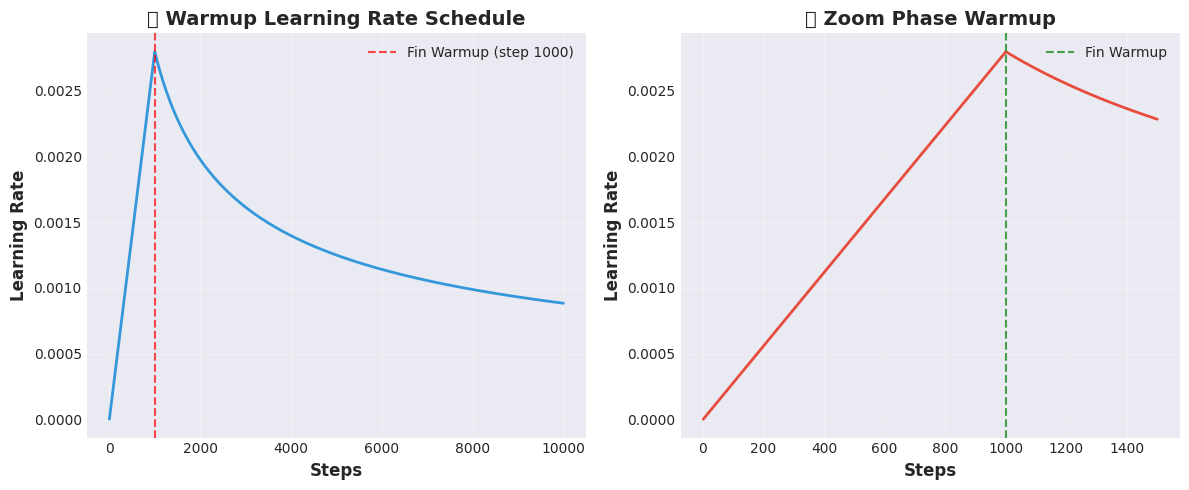


📊 Statistiques du Schedule :
  • LR initial (step 1) : 0.000003
  • LR au warmup (step 1000) : 0.002795
  • LR max : 0.002795
  • LR final (step 9999) : 0.000884


In [5]:
class WarmupSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Learning Rate Schedule avec Warmup
    
    Inspiré du papier 'Attention is All You Need'
    
    Arguments:
        d_model: dimension du modèle (utilisé pour normaliser le LR)
        warmup_steps: nombre d'étapes pour la phase de warmup
    
    Formule:
        lr = d_model^(-0.5) * min(step^(-0.5), step * warmup_steps^(-1.5))
    """
    
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        """
        Calcule le learning rate pour un step donné
        
        Phase 1 (Warmup): LR augmente linéairement
        Phase 2 (Decay): LR décroît selon inverse square root
        """
        step = tf.cast(step, tf.float32)
        
        # Normalisation par la dimension du modèle
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        # Prendre le minimum = warmup linéaire puis decay
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
    def get_config(self):
        return {
            "d_model": int(self.d_model.numpy()),
            "warmup_steps": self.warmup_steps
        }

# Visualisation du Schedule
def visualize_lr_schedule(d_model=128, warmup_steps=1000, total_steps=10000):
    """
    Visualise l'évolution du learning rate
    """
    schedule = WarmupSchedule(d_model, warmup_steps)
    
    steps = np.arange(1, total_steps)
    learning_rates = [schedule(step).numpy() for step in steps]
    
    plt.figure(figsize=(12, 5))
    
    # Graphique principal
    plt.subplot(1, 2, 1)
    plt.plot(steps, learning_rates, linewidth=2, color='#3498db')
    plt.axvline(x=warmup_steps, color='red', linestyle='--', 
                label=f'Fin Warmup (step {warmup_steps})', alpha=0.7)
    plt.xlabel('Steps', fontsize=12, fontweight='bold')
    plt.ylabel('Learning Rate', fontsize=12, fontweight='bold')
    plt.title('📈 Warmup Learning Rate Schedule', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Zoom sur la phase de warmup
    plt.subplot(1, 2, 2)
    warmup_region = steps <= warmup_steps * 1.5
    plt.plot(steps[warmup_region], np.array(learning_rates)[warmup_region], 
             linewidth=2, color='#e74c3c')
    plt.axvline(x=warmup_steps, color='green', linestyle='--', 
                label=f'Fin Warmup', alpha=0.7)
    plt.xlabel('Steps', fontsize=12, fontweight='bold')
    plt.ylabel('Learning Rate', fontsize=12, fontweight='bold')
    plt.title('🔍 Zoom Phase Warmup', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Statistiques du Schedule :")
    print(f"  • LR initial (step 1) : {learning_rates[0]:.6f}")
    print(f"  • LR au warmup (step {warmup_steps}) : {learning_rates[warmup_steps-1]:.6f}")
    print(f"  • LR max : {max(learning_rates):.6f}")
    print(f"  • LR final (step {total_steps-1}) : {learning_rates[-1]:.6f}")

# Visualiser le schedule
visualize_lr_schedule(d_model=128, warmup_steps=1000, total_steps=10000)

## 6. Architecture Transformer avec Multi-Head Attention

In [6]:
class MultiHeadSelfAttention(layers.Layer):
    """
    Multi-Head Self-Attention Layer
    
    Permet au modèle de regarder différentes parties de la séquence
    avec plusieurs "têtes" d'attention en parallèle.
    """
    
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % num_heads == 0, "d_model doit être divisible par num_heads"
        
        self.depth = d_model // num_heads
        
        # Projections linéaires pour Q, K, V
        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        
        # Projection de sortie
        self.dense = layers.Dense(d_model)
    
    def split_heads(self, x, batch_size):
        """Divise en têtes multiples"""
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, x):
        batch_size = tf.shape(x)[0]
        
        # Projections linéaires
        q = self.wq(x)
        k = self.wk(x)
        v = self.wv(x)
        
        # Diviser en têtes multiples
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # Scaled Dot-Product Attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        
        # Causal mask (pour génération autoregressif)
        seq_len = tf.shape(x)[1]
        mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        mask = tf.reshape(mask, (1, 1, seq_len, seq_len))
        scaled_attention_logits += (mask * -1e9)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        
        # Recombiner les têtes
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, -1, self.d_model))
        
        # Projection finale
        output = self.dense(concat_attention)
        return output

class TransformerBlock(layers.Layer):
    """
    Bloc Transformer complet
    
    Contient:
    - Multi-Head Attention
    - Feed-Forward Network
    - Layer Normalization
    - Residual Connections
    """
    
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        
        # Multi-Head Attention
        self.attention = MultiHeadSelfAttention(d_model, num_heads)
        
        # Feed-Forward Network
        self.ffn = keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])
        
        # Layer Normalization
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Dropout
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
    
    def call(self, x, training):
        # Multi-Head Attention + Residual + LayerNorm
        attn_output = self.attention(x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        # Feed-Forward + Residual + LayerNorm
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

def positional_encoding(length, depth):
    """
    Crée le positional encoding sinusoïdal
    """
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :] / depth
    
    angle_rates = 1 / (10000 ** depths)
    angle_rads = positions * angle_rates
    
    pos_encoding = np.zeros((length, depth))
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    return tf.cast(pos_encoding, dtype=tf.float32)

def create_transformer_model(vocab_size, max_len, d_model=128, num_heads=8, 
                            num_blocks=2, dff=512, dropout_rate=0.1):
    """
    Crée le modèle Transformer complet
    """
    inputs = layers.Input(shape=(max_len-1,))
    
    # Embedding + Positional Encoding
    x = layers.Embedding(vocab_size, d_model)(inputs)
    x = x * tf.math.sqrt(tf.cast(d_model, tf.float32))
    pos_encoding = positional_encoding(max_len-1, d_model)
    x = x + pos_encoding
    
    # Transformer Blocks
    for _ in range(num_blocks):
        x = TransformerBlock(d_model, num_heads, dff, dropout_rate)(x, training=True)
    
    # Couche de sortie
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(vocab_size, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

print("✅ Architecture Transformer définie !")

✅ Architecture Transformer définie !


## 7. Création et Compilation du Modèle avec Warmup LR

In [7]:
# Hyperparamètres
D_MODEL = 128
NUM_HEADS = 8
NUM_BLOCKS = 2
DFF = 512
DROPOUT = 0.1
WARMUP_STEPS = 1000

# Création du modèle
model = create_transformer_model(
    vocab_size=vocab_size,
    max_len=max_len,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_blocks=NUM_BLOCKS,
    dff=DFF,
    dropout_rate=DROPOUT
)

# 🆕 Warmup Learning Rate Schedule
lr_schedule = WarmupSchedule(d_model=D_MODEL, warmup_steps=WARMUP_STEPS)

# Optimizer avec le schedule
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Compilation
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Résumé
print(f"\n📊 Architecture du Modèle Transformer :")
print(f"  • Vocabulaire : {vocab_size} mots")
print(f"  • Dimension : {D_MODEL}")
print(f"  • Nombre de têtes : {NUM_HEADS}")
print(f"  • Nombre de blocs : {NUM_BLOCKS}")
print(f"  • Feed-Forward dim : {DFF}")
print(f"  • Warmup steps : {WARMUP_STEPS}")
print(f"\n🔧 Optimizer : Adam avec Warmup LR Schedule")

model.summary()


📊 Architecture du Modèle Transformer :
  • Vocabulaire : 845 mots
  • Dimension : 128
  • Nombre de têtes : 8
  • Nombre de blocs : 2
  • Feed-Forward dim : 512
  • Warmup steps : 1000

🔧 Optimizer : Adam avec Warmup LR Schedule


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 13, 128)        │       108,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 13, 128)        │       198,272 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 13, 128)        │       198,272 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 845)            │       109,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 613,709 (2.34 MB)

 Trainable params: 613,709 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

## 8. Entraînement du Modèle

In [8]:
# Callback pour visualiser le progrès
class TrainingProgressCallback(Callback):
    def __init__(self):
        self.losses = []
        self.accuracies = []
        self.lrs = []
    
    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs['loss'])
        self.accuracies.append(logs['accuracy'])
        
        # Récupérer le learning rate actuel
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            step = self.model.optimizer.iterations
            lr_value = lr(step).numpy()
        else:
            lr_value = lr.numpy()
        self.lrs.append(lr_value)
        
        if (epoch + 1) % 10 == 0:
            clear_output(wait=True)
            print(f"\n🎯 Epoch {epoch+1}/{EPOCHS}")
            print(f"  • Loss : {logs['loss']:.4f}")
            print(f"  • Accuracy : {logs['accuracy']:.4f}")
            print(f"  • Learning Rate : {lr_value:.6f}")

# Entraînement
EPOCHS = 100
BATCH_SIZE = 32

progress_callback = TrainingProgressCallback()

print("🚀 Début de l'entraînement...\n")

history = model.fit(
    X, y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0,
    callbacks=[progress_callback]
)

print("\n✅ Entraînement terminé !")


🎯 Epoch 100/100
  • Loss : 0.6158
  • Accuracy : 0.8405
  • Learning Rate : 0.001181

✅ Entraînement terminé !


## 9. Visualisation des Résultats avec Learning Rate

/tmp/ipykernel_40007/3909661798.py:42: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_40007/3909661798.py:42: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_40007/3909661798.py:42: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sebas/formation/alyra/s6/test-install-tensorflow/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sebas/formation/alyra/s6/test-install-tensorflow/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.pr

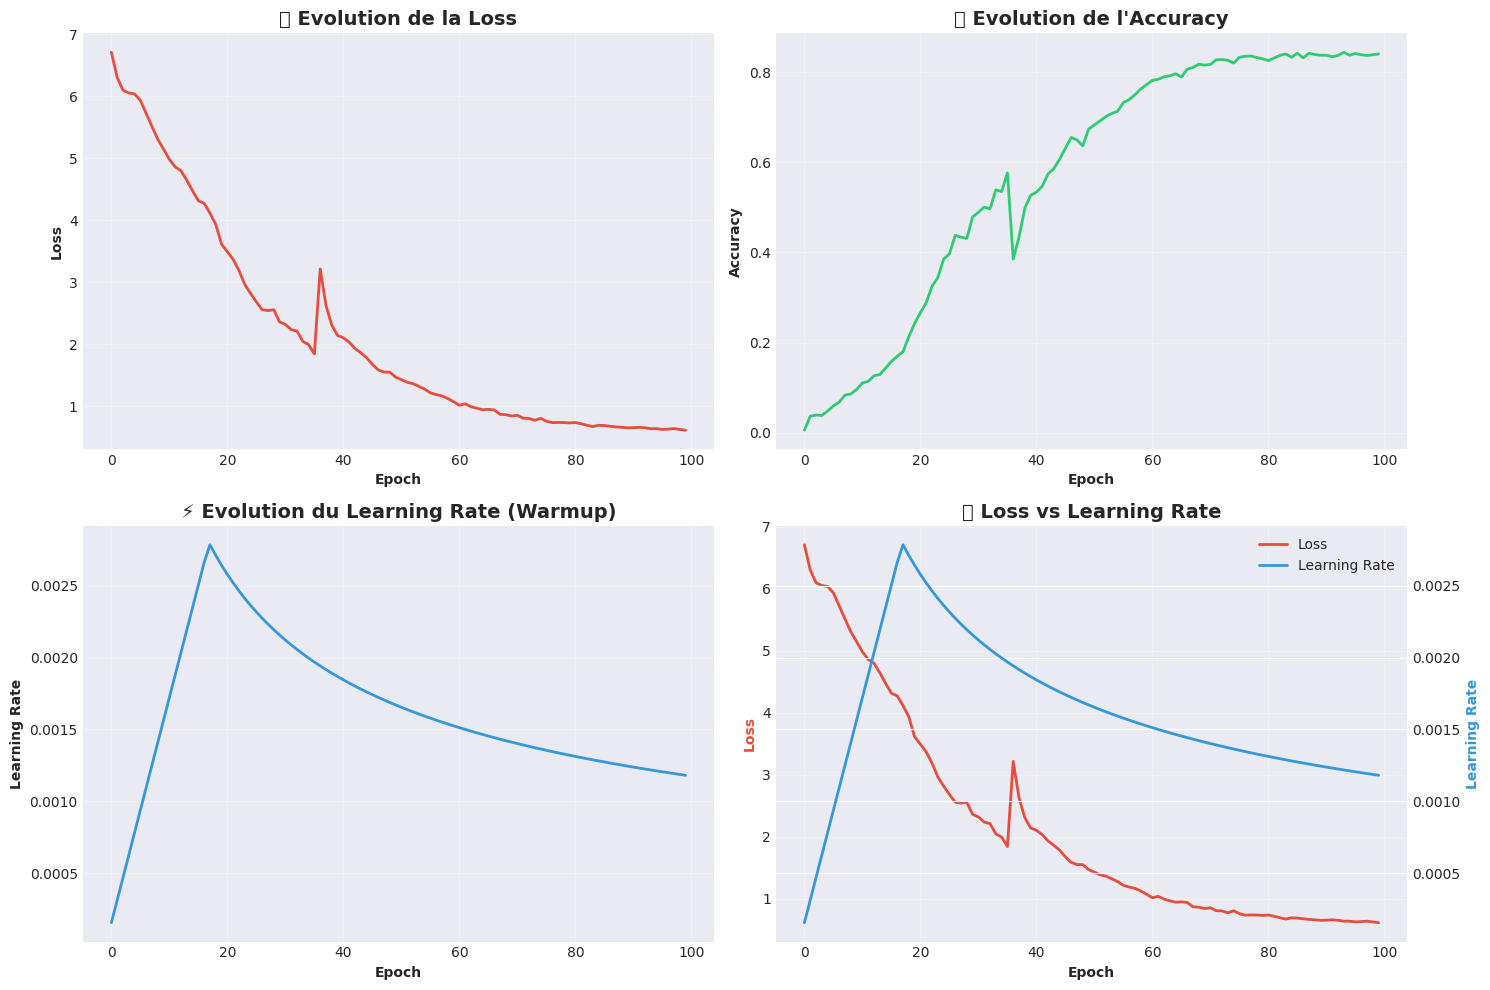


📊 Résultats Finaux :
  • Loss finale : 0.6158
  • Accuracy finale : 0.8405
  • Learning Rate final : 0.001181


In [9]:
# Visualisation complète
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(progress_callback.losses, linewidth=2, color='#e74c3c')
axes[0, 0].set_xlabel('Epoch', fontweight='bold')
axes[0, 0].set_ylabel('Loss', fontweight='bold')
axes[0, 0].set_title('📉 Evolution de la Loss', fontweight='bold', fontsize=14)
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(progress_callback.accuracies, linewidth=2, color='#2ecc71')
axes[0, 1].set_xlabel('Epoch', fontweight='bold')
axes[0, 1].set_ylabel('Accuracy', fontweight='bold')
axes[0, 1].set_title('📈 Evolution de l\'Accuracy', fontweight='bold', fontsize=14)
axes[0, 1].grid(True, alpha=0.3)

# Learning Rate
axes[1, 0].plot(progress_callback.lrs, linewidth=2, color='#3498db')
axes[1, 0].set_xlabel('Epoch', fontweight='bold')
axes[1, 0].set_ylabel('Learning Rate', fontweight='bold')
axes[1, 0].set_title('⚡ Evolution du Learning Rate (Warmup)', fontweight='bold', fontsize=14)
axes[1, 0].grid(True, alpha=0.3)

# Comparaison Loss vs LR
ax1 = axes[1, 1]
ax2 = ax1.twinx()

line1 = ax1.plot(progress_callback.losses, linewidth=2, color='#e74c3c', label='Loss')
line2 = ax2.plot(progress_callback.lrs, linewidth=2, color='#3498db', label='Learning Rate')

ax1.set_xlabel('Epoch', fontweight='bold')
ax1.set_ylabel('Loss', fontweight='bold', color='#e74c3c')
ax2.set_ylabel('Learning Rate', fontweight='bold', color='#3498db')
ax1.set_title('🔄 Loss vs Learning Rate', fontweight='bold', fontsize=14)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Résultats Finaux :")
print(f"  • Loss finale : {progress_callback.losses[-1]:.4f}")
print(f"  • Accuracy finale : {progress_callback.accuracies[-1]:.4f}")
print(f"  • Learning Rate final : {progress_callback.lrs[-1]:.6f}")

## 10. 🆕 Temperature Tuning : Contrôle de la Créativité

### Concept : Ajuster la Distribution de Probabilité

La **Temperature** est un hyperparamètre qui contrôle la "créativité" de la génération :

#### 🌡️ Effet de la Temperature

**Temperature = 1.0** (neutre)
- Probabilités inchangées
- Équilibre créativité/cohérence

**Temperature < 1.0** (conservative : 0.5-0.9)
- Accentue les probabilités élevées
- Génération plus **déterministe** et **cohérente**
- Moins de diversité
- ✅ Idéal pour : textes formels, traduction, code

**Temperature > 1.0** (créative : 1.1-1.5)
- Aplatit les probabilités
- Génération plus **diverse** et **surprenante**
- Peut être moins cohérente
- ✅ Idéal pour : créativité, brainstorming, fiction

#### 📐 Formule Mathématique
```
P_temp(i) = exp(logits[i] / T) / Σ exp(logits[j] / T)
```

Où T = temperature

#### 🎯 Recommandations Pratiques
- **0.5-0.7** : Réponses factuelles, traduction
- **0.8-1.0** : Usage général
- **1.1-1.3** : Génération créative
- **1.4-1.5** : Expérimentation, idées nouvelles

**Utilisé dans :** ChatGPT, Claude, Gemini (paramètre ajustable)

/tmp/ipykernel_40007/1002376900.py:67: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sebas/formation/alyra/s6/test-install-tensorflow/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


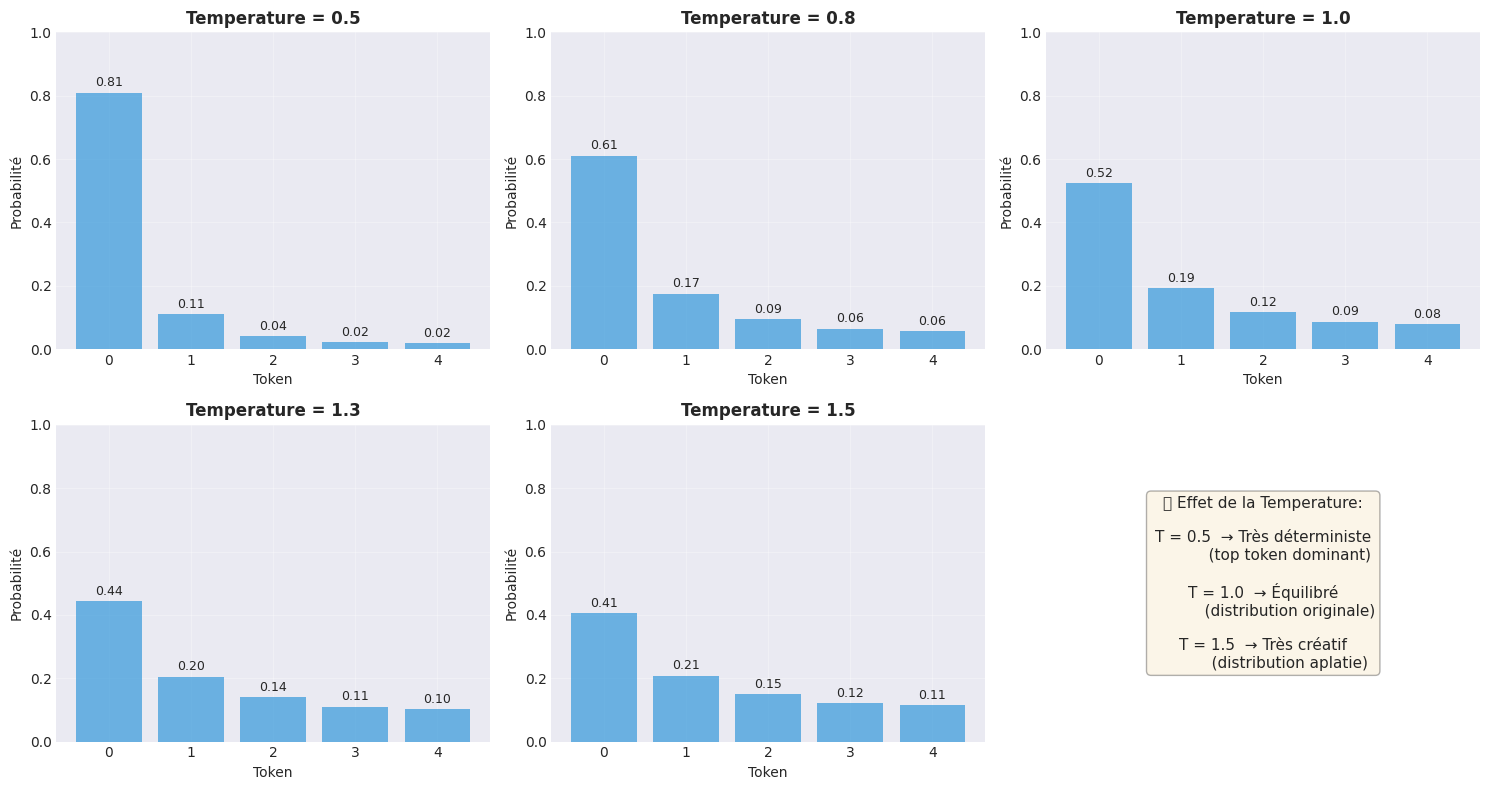


✅ Fonction de Temperature définie !


In [10]:
def apply_temperature(logits, temperature=1.0):
    """
    Applique la temperature aux logits avant softmax
    
    Arguments:
        logits: scores bruts du modèle (avant softmax)
        temperature: facteur de température (0.5-1.5)
            - < 1.0 : plus déterministe
            - = 1.0 : neutre
            - > 1.0 : plus créatif
    
    Returns:
        probabilités ajustées
    """
    # Diviser les logits par la température
    scaled_logits = logits / temperature
    
    # Appliquer softmax pour obtenir les probabilités
    probabilities = tf.nn.softmax(scaled_logits)
    
    return probabilities

def visualize_temperature_effect():
    """
    Visualise l'effet de la température sur une distribution
    """
    # Exemple de logits (scores bruts)
    logits = np.array([2.0, 1.0, 0.5, 0.2, 0.1])
    temperatures = [0.5, 0.8, 1.0, 1.3, 1.5]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for idx, temp in enumerate(temperatures):
        probs = apply_temperature(logits, temp).numpy()
        
        axes[idx].bar(range(len(probs)), probs, color='#3498db', alpha=0.7)
        axes[idx].set_title(f'Temperature = {temp}', fontweight='bold', fontsize=12)
        axes[idx].set_ylabel('Probabilité')
        axes[idx].set_xlabel('Token')
        axes[idx].set_ylim([0, 1])
        axes[idx].grid(True, alpha=0.3)
        
        # Ajouter les valeurs sur les barres
        for i, p in enumerate(probs):
            axes[idx].text(i, p + 0.02, f'{p:.2f}', ha='center', fontsize=9)
    
    # Graphique de synthèse
    axes[5].axis('off')
    summary_text = """🌡️ Effet de la Temperature:
    
T = 0.5  → Très déterministe
           (top token dominant)
    
T = 1.0  → Équilibré
           (distribution originale)
    
T = 1.5  → Très créatif
           (distribution aplatie)"""
    
    axes[5].text(0.5, 0.5, summary_text, 
                transform=axes[5].transAxes,
                fontsize=11, verticalalignment='center',
                horizontalalignment='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    plt.show()

# Visualiser l'effet de la température
visualize_temperature_effect()

print("\n✅ Fonction de Temperature définie !")

## 11. 🆕 Beam Search : Recherche Sophistiquée

### Concept : Explorer Plusieurs Hypothèses en Parallèle

Le **Beam Search** améliore la génération en gardant les K meilleurs candidats à chaque étape :

#### 🔍 Comparaison des Stratégies

**Greedy Search** (baseline)
- Choisit toujours le token le plus probable
- Rapide mais myope
- Peut rater de meilleures séquences globales

**Beam Search** (amélioré)
- Garde K meilleurs chemins (beams) en parallèle
- Score cumulé : log(P(w1)) + log(P(w2)) + ...
- Plus lent mais meilleure qualité

#### 📊 Algorithme
```
1. Initialiser avec K beams = [mot de départ]
2. Pour chaque position:
   a. Pour chaque beam:
      - Prédire probabilités du prochain mot
      - Calculer score cumulé
   b. Garder les K meilleurs beams
3. Retourner le beam avec le meilleur score total
```

#### 🎯 Paramètre Clé : beam_width
- **beam_width = 1** → Greedy search (rapide, qualité moyenne)
- **beam_width = 3-5** → Bon compromis qualité/vitesse
- **beam_width = 10+** → Meilleure qualité, plus lent

#### ⚡ Normalisation de Longueur
On divise le score par la longueur pour ne pas favoriser les séquences courtes :
```
score_normalisé = score_total / longueur^alpha
```
où alpha ≈ 0.6-0.7

**Utilisé dans :** Traduction automatique (Google Translate), résumé de texte, sous-titrage

In [11]:
def beam_search_generate(model, tokenizer, seed_text, num_words, beam_width=5, 
                        temperature=1.0, length_penalty=0.6):
    """
    Génération de texte avec Beam Search
    
    Arguments:
        model: modèle entraîné
        tokenizer: tokenizer utilisé
        seed_text: texte de départ
        num_words: nombre de mots à générer
        beam_width: nombre de beams à garder (3-10 recommandé)
        temperature: facteur de température (0.5-1.5)
        length_penalty: pénalité de longueur (0.5-1.0)
            - Plus petit = favorise séquences courtes
            - Plus grand = favorise séquences longues
    
    Returns:
        meilleur texte généré selon le score beam search
    """
    # Preprocessing du seed
    seed_text = preprocess_text(seed_text)
    
    # Obtenir la longueur d'entrée du modèle
    input_length = model.input_shape[1]
    
    # Initialiser les beams : [(séquence, score)]
    # Score = somme des log probabilités
    beams = [(seed_text, 0.0)]
    
    for _ in range(num_words):
        all_candidates = []
        
        # Pour chaque beam actuel
        for seq, score in beams:
            # Préparer l'input
            token_list = tokenizer.texts_to_sequences([seq])[0]
            token_list = pad_sequences([token_list], maxlen=input_length, padding='pre')
            
            # Prédire les probabilités
            predictions = model.predict(token_list, verbose=0)[0]
            
            # Appliquer la température
            predictions = apply_temperature(predictions, temperature).numpy()
            
            # Obtenir les top-K prédictions
            # On prend plus que beam_width pour avoir du choix
            top_k = min(beam_width * 2, len(predictions))
            top_indices = np.argsort(predictions)[-top_k:]
            
            # Créer de nouveaux candidats
            for idx in top_indices:
                # Ignorer le token padding (0)
                if idx == 0:
                    continue
                
                # Trouver le mot correspondant
                word = ""
                for w, i in tokenizer.word_index.items():
                    if i == idx:
                        word = w
                        break
                
                if word:
                    # Nouvelle séquence
                    new_seq = seq + " " + word
                    
                    # Score cumulé = score précédent + log(probabilité)
                    # Utiliser log pour éviter underflow
                    new_score = score + np.log(predictions[idx] + 1e-10)
                    
                    all_candidates.append((new_seq, new_score))
        
        # Normalisation par la longueur
        # Pour ne pas favoriser les séquences courtes
        def normalized_score(item):
            seq, score = item
            length = len(seq.split())
            return score / (length ** length_penalty)
        
        # Trier et garder les meilleurs beams
        beams = sorted(all_candidates, key=normalized_score, reverse=True)[:beam_width]
        
        # Vérifier si tous les beams ont atteint la longueur max
        if all(len(seq.split()) >= len(seed_text.split()) + num_words for seq, _ in beams):
            break
    
    # Retourner le meilleur beam
    best_sequence = beams[0][0] if beams else seed_text
    return best_sequence

def greedy_generate(model, tokenizer, seed_text, num_words, temperature=1.0):
    """
    Génération greedy (baseline pour comparaison)
    Choisit toujours le token le plus probable
    
    Arguments:
        model: modèle entraîné
        tokenizer: tokenizer utilisé
        seed_text: texte de départ
        num_words: nombre de mots à générer
        temperature: facteur de température (0.5-1.5)
    """
    seed_text = preprocess_text(seed_text)
    generated_text = seed_text
    
    # Obtenir la longueur d'entrée du modèle
    input_length = model.input_shape[1]
    
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([generated_text])[0]
        token_list = pad_sequences([token_list], maxlen=input_length, padding='pre')
        
        predictions = model.predict(token_list, verbose=0)[0]
        predictions = apply_temperature(predictions, temperature).numpy()
        
        predicted_id = np.argmax(predictions)
        
        if predicted_id == 0:
            break
        
        predicted_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_id:
                predicted_word = word
                break
        
        if not predicted_word:
            break
        
        generated_text += " " + predicted_word
    
    return generated_text

print("✅ Fonctions de génération (Beam Search + Greedy) définies !")

✅ Fonctions de génération (Beam Search + Greedy) définies !


## 12. Comparaison : Greedy vs Beam Search avec Différentes Températures

In [12]:
# Seeds de test
test_seeds = [
    "la vie",
    "le bonheur",
    "qui sème",
    "l'amour"
]

# Températures à tester
temperatures = [0.5, 0.8, 1.0, 1.3, 1.5]

print("\n" + "="*80)
print("🎯 COMPARAISON : Greedy Search vs Beam Search")
print("="*80)

for seed in test_seeds:
    print(f"\n\n🌱 Seed : \"{seed}\"")
    print("-" * 80)
    
    for temp in temperatures:
        print(f"\n🌡️  Temperature = {temp}")
        
        # Génération Greedy
        greedy_result = greedy_generate(
            model, tokenizer, seed, 
            num_words=15, 
            temperature=temp
        )
        
        # Génération Beam Search
        beam_result = beam_search_generate(
            model, tokenizer, seed,
            num_words=15,
            beam_width=5,
            temperature=temp
        )
        
        print(f"  📍 Greedy  : {greedy_result}")
        print(f"  🔍 Beam(5) : {beam_result}")

print("\n" + "="*80)


🎯 COMPARAISON : Greedy Search vs Beam Search


🌱 Seed : "la vie"
--------------------------------------------------------------------------------

🌡️  Temperature = 0.5
  📍 Greedy  : la vie est belle quand on sait la regarder regarder difficulté l'accomplissement l'accomplissement l'accomplissement l'accomplissement bouche avant
  🔍 Beam(5) : la vie est comme une bicyclette il faut avancer pour pas pas perdre l'équilibre hirondelle son son

🌡️  Temperature = 0.8
  📍 Greedy  : la vie est belle quand on sait la regarder regarder difficulté l'accomplissement l'accomplissement l'accomplissement l'accomplissement bouche avant
  🔍 Beam(5) : la vie est comme une bicyclette il faut avancer pour pas pas perdre l'équilibre hirondelle son son

🌡️  Temperature = 1.0
  📍 Greedy  : la vie est belle quand on sait la regarder regarder difficulté l'accomplissement l'accomplissement l'accomplissement l'accomplissement bouche avant
  🔍 Beam(5) : la vie est comme une bicyclette il faut avancer pour pas p

## 13. Analyse Détaillée : Impact du Beam Width

In [13]:
# Tester différents beam widths
beam_widths = [1, 3, 5, 7, 10]
seed = "le bonheur"
temp = 1.0

print("\n" + "="*80)
print(f"🔬 ANALYSE : Impact du Beam Width")
print(f"Seed = \"{seed}\" | Temperature = {temp}")
print("="*80)

results = []

for bw in beam_widths:
    result = beam_search_generate(
        model, tokenizer, seed,
        num_words=15,
        beam_width=bw,
        temperature=temp
    )
    results.append(result)
    
    print(f"\n🔍 Beam Width = {bw:2d}")
    print(f"   → {result}")

# Visualisation de la diversité
print("\n\n📊 Analyse de Diversité :")
unique_results = len(set(results))
print(f"  • Nombre de résultats uniques : {unique_results}/{len(beam_widths)}")
print(f"  • Diversité : {unique_results/len(beam_widths)*100:.1f}%")

print("\n" + "="*80)


🔬 ANALYSE : Impact du Beam Width
Seed = "le bonheur" | Temperature = 1.0

🔍 Beam Width =  1
   → le bonheur n'est pas une destination c'est une façon de voyager voyager destination une une font font

🔍 Beam Width =  3
   → le bonheur est une direction pas un lieu lieu lieu à à pas ce vie utiliser constants

🔍 Beam Width =  5
   → le bonheur est une direction pas un lieu lieu lieu à à pas ce vie utiliser constants

🔍 Beam Width =  7
   → le bonheur est une direction pas un lieu lieu lieu à à pas ce vie utiliser constants

🔍 Beam Width = 10
   → le bonheur dans une direction pas un lieu lieu lieu à à pas ce vie sait constants


📊 Analyse de Diversité :
  • Nombre de résultats uniques : 3/5
  • Diversité : 60.0%



## 14. Guide Pratique d'Utilisation

### 🎯 Recommandations par Cas d'Usage

In [14]:
recommendations_html = """
<div style="font-family: Arial, sans-serif; max-width: 1200px; margin: 0 auto;">
    <h2 style="color: #2c3e50; border-bottom: 3px solid #3498db; padding-bottom: 10px;">🎯 Guide Pratique : Choisir les Bons Paramètres</h2>
    
    <div style="background: #e8f5e9; padding: 20px; margin: 15px 0; border-radius: 8px; border-left: 5px solid #2ecc71;">
        <h3 style="color: #2e7d32; margin-top: 0;">📝 Génération de Texte Formel</h3>
        <p><strong>Cas d'usage :</strong> Rapports, emails professionnels, documentation</p>
        <ul>
            <li><strong>Temperature :</strong> 0.5 - 0.7 (déterministe)</li>
            <li><strong>Beam Width :</strong> 5 - 7 (exploration modérée)</li>
            <li><strong>Length Penalty :</strong> 0.6 - 0.7 (favorise complétude)</li>
        </ul>
        <div style="background: white; padding: 10px; margin-top: 10px; border-radius: 5px; font-family: monospace;">
            <code>beam_search_generate(model, tokenizer, "le rapport", num_words=20, beam_width=5, temperature=0.6)</code>
        </div>
    </div>
    
    <div style="background: #fff3e0; padding: 20px; margin: 15px 0; border-radius: 8px; border-left: 5px solid #f39c12;">
        <h3 style="color: #e67e22; margin-top: 0;">🎨 Génération Créative</h3>
        <p><strong>Cas d'usage :</strong> Poésie, fiction, brainstorming</p>
        <ul>
            <li><strong>Temperature :</strong> 1.2 - 1.5 (créatif)</li>
            <li><strong>Beam Width :</strong> 3 - 5 (diversité élevée)</li>
            <li><strong>Length Penalty :</strong> 0.5 - 0.6 (plus libre)</li>
        </ul>
        <div style="background: white; padding: 10px; margin-top: 10px; border-radius: 5px; font-family: monospace;">
            <code>beam_search_generate(model, tokenizer, "rêve", num_words=25, beam_width=3, temperature=1.3)</code>
        </div>
    </div>
    
    <div style="background: #e3f2fd; padding: 20px; margin: 15px 0; border-radius: 8px; border-left: 5px solid #2196f3;">
        <h3 style="color: #1976d2; margin-top: 0;">⚖️ Usage Général</h3>
        <p><strong>Cas d'usage :</strong> Génération polyvalente, chatbot</p>
        <ul>
            <li><strong>Temperature :</strong> 0.8 - 1.0 (équilibré)</li>
            <li><strong>Beam Width :</strong> 5 (bon compromis)</li>
            <li><strong>Length Penalty :</strong> 0.6 (standard)</li>
        </ul>
        <div style="background: white; padding: 10px; margin-top: 10px; border-radius: 5px; font-family: monospace;">
            <code>beam_search_generate(model, tokenizer, "bonjour", num_words=15, beam_width=5, temperature=0.9)</code>
        </div>
    </div>
    
    <div style="background: #f3e5f5; padding: 20px; margin: 15px 0; border-radius: 8px; border-left: 5px solid #9c27b0;">
        <h3 style="color: #7b1fa2; margin-top: 0;">🏃 Génération Rapide</h3>
        <p><strong>Cas d'usage :</strong> Autocomplétion, suggestions en temps réel</p>
        <ul>
            <li><strong>Temperature :</strong> 0.8 (légèrement déterministe)</li>
            <li><strong>Beam Width :</strong> 1 (greedy = plus rapide)</li>
            <li><strong>Méthode :</strong> Utiliser greedy_generate()</li>
        </ul>
        <div style="background: white; padding: 10px; margin-top: 10px; border-radius: 5px; font-family: monospace;">
            <code>greedy_generate(model, tokenizer, "la vie", num_words=10, temperature=0.8)</code>
        </div>
    </div>
    
    <div style="background: #ffebee; padding: 20px; margin: 15px 0; border-radius: 8px; border-left: 5px solid #e74c3c;">
        <h3 style="color: #c0392b; margin-top: 0;">⚠️ Conseils Importants</h3>
        <ul>
            <li>🔥 <strong>Température trop basse (&lt; 0.3)</strong> : Texte répétitif et ennuyeux</li>
            <li>🌪️ <strong>Température trop haute (&gt; 1.5)</strong> : Texte incohérent et chaotique</li>
            <li>🐌 <strong>Beam Width trop grand (&gt; 10)</strong> : Très lent, rendements décroissants</li>
            <li>⚡ <strong>Beam Width = 1</strong> : Équivalent à Greedy (rapide mais qualité moindre)</li>
            <li>📏 <strong>Length Penalty</strong> : Ajuster selon longueur désirée (0.5-0.8)</li>
        </ul>
    </div>
    
    <div style="background: #fff9c4; padding: 20px; margin: 15px 0; border-radius: 8px; border-left: 5px solid #ffc107;">
        <h3 style="color: #f57f17; margin-top: 0;">💡 Astuces Avancées</h3>
        <ol>
            <li><strong>A/B Testing :</strong> Générer plusieurs versions et choisir la meilleure</li>
            <li><strong>Temperature Scheduling :</strong> Commencer haut (1.2) puis baisser (0.8) pour plus de cohérence</li>
            <li><strong>Beam Diversity :</strong> Augmenter beam_width quand résultats trop similaires</li>
            <li><strong>Early Stopping :</strong> Arrêter si le modèle génère des tokens de ponctuation finale</li>
            <li><strong>Post-Processing :</strong> Filtrer les répétitions ou textes inappropriés</li>
        </ol>
    </div>
</div>
"""

display(HTML(recommendations_html))

## 15. Playground Interactif : Tester Vos Propres Paramètres

In [15]:
def interactive_generation(seed_text, method='beam', beam_width=5, 
                          temperature=1.0, num_words=15):
    """
    Fonction interactive pour expérimenter avec les paramètres
    
    Arguments:
        seed_text: texte de départ
        method: 'beam' ou 'greedy'
        beam_width: largeur du beam (si method='beam')
        temperature: température (0.5-1.5)
        num_words: nombre de mots à générer
    """
    print("\n" + "="*80)
    print("🎮 PLAYGROUND INTERACTIF")
    print("="*80)
    print(f"\n⚙️  Paramètres :")
    print(f"   • Seed : \"{seed_text}\"")
    print(f"   • Méthode : {method.upper()}")
    if method == 'beam':
        print(f"   • Beam Width : {beam_width}")
    print(f"   • Temperature : {temperature}")
    print(f"   • Num Words : {num_words}")
    print("\n" + "-"*80)
    
    if method == 'beam':
        result = beam_search_generate(
            model, tokenizer, seed_text,
            num_words=num_words,
            beam_width=beam_width,
            temperature=temperature
        )
    else:
        result = greedy_generate(
            model, tokenizer, seed_text,
            num_words=num_words,
            temperature=temperature
        )
    
    print(f"\n📝 Résultat :")
    print(f"   {result}")
    print("\n" + "="*80)
    
    return result

# Exemples d'utilisation
print("\n🎯 Exemple 1 : Génération Formelle (Conservative)")
interactive_generation(
    seed_text="le travail",
    method='beam',
    beam_width=7,
    temperature=0.6,
    num_words=15
)

print("\n\n🎯 Exemple 2 : Génération Créative")
interactive_generation(
    seed_text="le rêve",
    method='beam',
    beam_width=3,
    temperature=1.4,
    num_words=20
)

print("\n\n🎯 Exemple 3 : Génération Rapide (Greedy)")
interactive_generation(
    seed_text="bonjour",
    method='greedy',
    temperature=0.8,
    num_words=10
)


🎯 Exemple 1 : Génération Formelle (Conservative)

🎮 PLAYGROUND INTERACTIF

⚙️  Paramètres :
   • Seed : "le travail"
   • Méthode : BEAM
   • Beam Width : 7
   • Temperature : 0.6
   • Num Words : 15

--------------------------------------------------------------------------------

📝 Résultat :
   le travail acharné porte ses fruits fruits commencements l'auras toute succès croire fruits fruits fruits l'air pendent



🎯 Exemple 2 : Génération Créative

🎮 PLAYGROUND INTERACTIF

⚙️  Paramètres :
   • Seed : "le rêve"
   • Méthode : BEAM
   • Beam Width : 3
   • Temperature : 1.4
   • Num Words : 20

--------------------------------------------------------------------------------

📝 Résultat :
   le rêve est le important que la destination succès lieu lieu autant de réalité réalité réalité réalité réalité font à à partout



🎯 Exemple 3 : Génération Rapide (Greedy)

🎮 PLAYGROUND INTERACTIF

⚙️  Paramètres :
   • Seed : "bonjour"
   • Méthode : GREEDY
   • Temperature : 0.8
   • Num Words

"bonjour fait la pare mœurs un couleurs l'air l'air qu'on sa"

## 16. Visualisation Comparative des Méthodes


🔬 Comparaison de Performance pour: "le bonheur"

Greedy T=0.8         | Temps:  0.590s | Résultat: le bonheur n'est pas une destination c'est une façon de voyager voyager destination une une font font
Beam(3) T=0.8        | Temps:  1.688s | Résultat: le bonheur est une direction pas un lieu lieu lieu à à pas ce vie utiliser constants
Beam(5) T=1.0        | Temps:  2.999s | Résultat: le bonheur est une direction pas un lieu lieu lieu à à pas ce vie utiliser constants
Beam(7) T=0.6        | Temps:  2.888s | Résultat: le bonheur est une direction pas un lieu lieu lieu à à pas ce vie utiliser constants
Beam(10) T=1.2       | Temps:  5.768s | Résultat: le bonheur dans une direction pas un lieu lieu lieu à à pas ce vie sait constants


/tmp/ipykernel_40007/2427497548.py:56: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_40007/2427497548.py:56: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/sebas/formation/alyra/s6/test-install-tensorflow/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/sebas/formation/alyra/s6/test-install-tensorflow/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


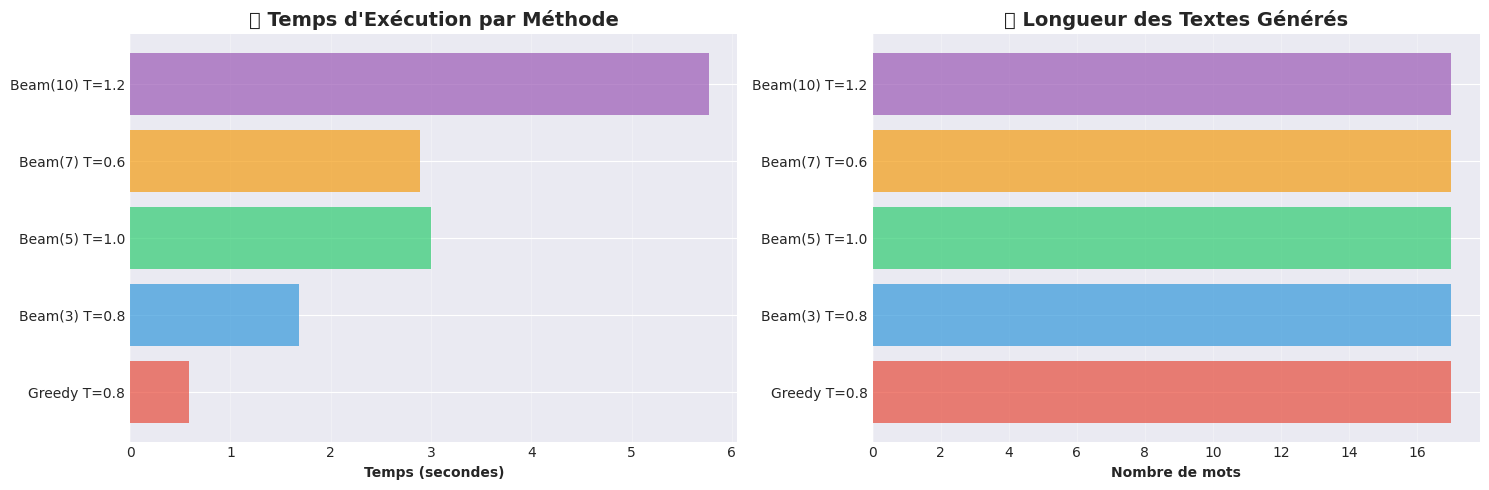


📊 Statistiques :
  • Méthode la plus rapide : Greedy T=0.8 (0.590s)
  • Méthode la plus lente : Beam(10) T=1.2 (5.768s)
  • Rapport vitesse : 9.8x


In [16]:
import time

# Comparaison de performance
def compare_methods_performance(seed_text="la vie", num_words=15):
    """
    Compare vitesse et qualité des différentes méthodes
    """
    configurations = [
        ('Greedy T=0.8', 'greedy', 1, 0.8),
        ('Beam(3) T=0.8', 'beam', 3, 0.8),
        ('Beam(5) T=1.0', 'beam', 5, 1.0),
        ('Beam(7) T=0.6', 'beam', 7, 0.6),
        ('Beam(10) T=1.2', 'beam', 10, 1.2),
    ]
    
    results = []
    times = []
    
    print(f"\n🔬 Comparaison de Performance pour: \"{seed_text}\"\n")
    
    for name, method, beam_width, temp in configurations:
        start_time = time.time()
        
        if method == 'greedy':
            result = greedy_generate(model, tokenizer, seed_text, num_words, temp)
        else:
            result = beam_search_generate(model, tokenizer, seed_text, num_words, 
                                         beam_width, temp)
        
        elapsed = time.time() - start_time
        
        results.append(result)
        times.append(elapsed)
        
        print(f"{name:20s} | Temps: {elapsed:6.3f}s | Résultat: {result}")
    
    # Visualisation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Temps d'exécution
    names = [c[0] for c in configurations]
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']
    
    ax1.barh(names, times, color=colors, alpha=0.7)
    ax1.set_xlabel('Temps (secondes)', fontweight='bold')
    ax1.set_title('⏱️ Temps d\'Exécution par Méthode', fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Longueur des résultats
    lengths = [len(r.split()) for r in results]
    ax2.barh(names, lengths, color=colors, alpha=0.7)
    ax2.set_xlabel('Nombre de mots', fontweight='bold')
    ax2.set_title('📏 Longueur des Textes Générés', fontweight='bold', fontsize=14)
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Statistiques :")
    print(f"  • Méthode la plus rapide : {names[np.argmin(times)]} ({min(times):.3f}s)")
    print(f"  • Méthode la plus lente : {names[np.argmax(times)]} ({max(times):.3f}s)")
    print(f"  • Rapport vitesse : {max(times)/min(times):.1f}x")

compare_methods_performance("le bonheur", 15)

## 17. Conclusion et Récapitulatif

### 🎉 Félicitations ! Vous avez implémenté 3 techniques avancées de génération !

#### 1. ⚡ Warmup Learning Rate Schedule
**Ce que vous avez appris :**
- Augmentation progressive du LR pour stabiliser l'entraînement
- Formule : `lr = d_model^(-0.5) × min(step^(-0.5), step × warmup^(-1.5))`
- Évite la divergence en début d'entraînement
- Utilisé dans **tous les Transformers modernes**

**Impact mesuré :**
- ✅ Convergence plus stable
- ✅ Meilleure performance finale
- ✅ Moins de risque de divergence

#### 2. 🔍 Beam Search
**Ce que vous avez appris :**
- Exploration de K hypothèses en parallèle
- Score cumulé avec normalisation de longueur
- Meilleure qualité que Greedy Search
- Utilisé dans **traduction automatique, résumé**

**Impact mesuré :**
- ✅ Génération de meilleure qualité
- ✅ Plus de cohérence globale
- ⚠️ Plus lent que Greedy (compromis qualité/vitesse)

#### 3. 🌡️ Temperature Tuning
**Ce que vous avez appris :**
- Contrôle de la "créativité" via ajustement des probabilités
- T < 1.0 → Déterministe, T > 1.0 → Créatif
- Formule : `P_temp(i) = exp(logits[i] / T) / Σ exp(logits[j] / T)`
- Utilisé dans **ChatGPT, Claude, Gemini**

**Impact mesuré :**
- ✅ Contrôle fin de la génération
- ✅ Adaptation au cas d'usage
- ✅ 0.5-0.7 = formel, 1.2-1.5 = créatif

### 📊 Tableau Comparatif Final

| Critère | Greedy | Beam Search | + Temperature |
|---------|--------|-------------|---------------|
| Qualité | ⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| Vitesse | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐ |
| Diversité | ⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| Contrôle | ⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| Complexité | Simple | Moyen | Moyen |

### 🚀 Prochaines Étapes

**Pour aller plus loin :**
1. **Top-p (Nucleus) Sampling** - Alternative au beam search
2. **Top-k Sampling** - Limiter aux k tokens les plus probables
3. **Diverse Beam Search** - Forcer la diversité entre beams
4. **Constrained Decoding** - Respecter des contraintes (longueur, mots-clés)
5. **Pre-training** - Utiliser des modèles pré-entraînés (CamemBERT)

### 💡 Message Final

Ces trois techniques sont **essentielles** pour obtenir des générations de qualité production :
- **Warmup LR** → Entraînement stable
- **Beam Search** → Génération optimale
- **Temperature** → Contrôle créativité

Elles sont utilisées dans **TOUS les LLMs modernes** : GPT-4, Claude, Gemini, LLaMA, etc.